# fashion mnist のデータセットを用いて，ソフトマックス回帰を実装してください．

## 目標スコア
テストデータによるスコア$\geq$**78%**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def np_log(x):
    """
    log関数のオーバーフローを防ぐ実装，clipで値を制限
    """
    return np.log(np.clip(x, 1e-10, 1e+10))

def softmax(x, axis=1):
    # expのoverflowを防ぐ，定数項を引いても値は変わらない
    # keepdims: 次元を合わせる，max関数を使うと次元が減る（shapeが変わる）のでそれを避ける．
    x -= x.max(axis, keepdims=True)
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis, keepdims=True)

In [21]:
class SoftmaxRegression():
    def __init__(self, in_dim, out_dim, optimizer="sgd", v=0, mu=0):
        """
        パラメータの初期化を行う．
        in_dim: 入力次元数
        out_dim: 出力次元数（ラベルの数）
        """
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype('float32')
        self.b = np.zeros(shape=(1, out_dim)).astype('float32')

        # optimizer 選択
        self.optimizer = optimizer

        # momentum用
        self.vw = v
        self.vb = v
        self.mu = mu

        # adam用
        self.p_t_w = 0
        self.p_t_b = 0
        self.q_t_w = 0
        self.q_t_b = 0

    def predict(self, x):
        Z = x @ self.W + self.b
        return softmax(Z)

    def cost(self, y_true, y_pred):
        """
        y_true: 真の値
        y_pred: ソフトマックス後の予測値（確率値）
        """
        # WRITE ME
        J = (- y_true * np_log(y_pred)).sum(axis=1).mean()
        return J

    def update(self, X, Y, alpha, m_1=0.9, m_2=0.999, eps=10e-8, t=-1):
        # WRITEME

        # 予測値の計算
        Y_hat = self.predict(X)

        # 誤差の計算
        delta = Y - Y_hat # WRITEME

        # 勾配の計算
        dW = -X.T @ delta / X.shape[0] # WRITEME
        db = -delta.mean(axis=0) # WRITEME

        # パラメータの更新
        if self.optimizer == "momentum":
            self.vw = self.mu * self.vw - alpha * dW
            self.vb = self.mu * self.vb - alpha * db
            self.W += self.vw
            self.b += self.vb

        elif self.optimizer == "adam":

            self.p_t_w = m_1 * self.p_t_w + (1 - m_1) * dW
            self.p_t_b = m_1 * self.p_t_b + (1 - m_1) * db
            self.q_t_w = m_2 * self.q_t_w + (1 - m_2) * dW**2
            self.q_t_b = m_2 * self.q_t_b + (1 - m_2) * db**2

            p_t_w_hat = self.p_t_w / (1 - (m_1)**(t+1))
            p_t_b_hat = self.p_t_b / (1 - (m_1)**(t+1))
            q_t_w_hat = self.q_t_w / (1 - (m_2)**(t+1))
            q_t_b_hat = self.q_t_b / (1 - (m_2)**(t+1))

            self.W -= alpha * p_t_w_hat * (np.sqrt(q_t_w_hat) + eps)
            self.b -= alpha * p_t_b_hat * (np.sqrt(q_t_b_hat) + eps)
        else:
            self.W -= alpha * dW
            self.b -= alpha * db

        return self.cost(Y, self.predict(X))

4422102/4422102 [==============================] - 0s 0us/step


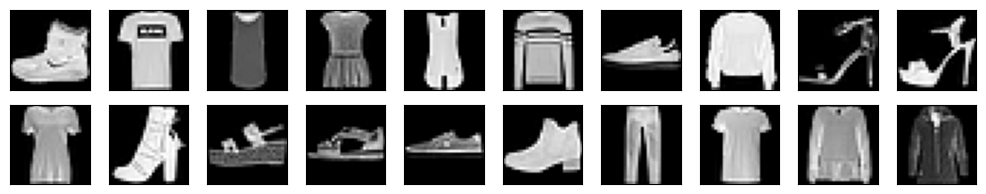

In [4]:
# fashion_mnistデータセットを学習させる
# fashion_mnist: 服や靴，帽子などの画像データ．10ラベル
from keras.datasets import fashion_mnist as fmnist
(x_fmnist_1, y_fmnist_1), (x_fmnist_2, y_fmnist_2) = fmnist.load_data()

x_fmnist = np.r_[x_fmnist_1, x_fmnist_2]
y_fmnist = np.r_[y_fmnist_1, y_fmnist_2]

fig = plt.figure(figsize=(10, 10))

for i in range(20):
    x = x_fmnist[i]
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [5]:
# データの前処理：正規化や一次元化したりする．
# データの分割；今回は訓練データとテストデータに分け，さらに訓練データを検証用データと訓練データに分けた．
from sklearn.model_selection import train_test_split
x_fmnist = x_fmnist.astype('float32') / 255.
y_fmnist = np.eye(N=10)[y_fmnist.astype('int32').flatten()]

x_fmnist=x_fmnist.reshape(x_fmnist.shape[0],-1)

x_train_fmnist, x_test_fmnist, y_train_fmnist, y_test_fmnist = train_test_split(x_fmnist, y_fmnist, test_size=10000)
x_train_fmnist, x_valid_fmnist, y_train_fmnist, y_valid_fmnist = train_test_split(x_train_fmnist, y_train_fmnist, test_size=10000)

In [25]:
# 学習
# モデルのインスタンスを生成
from sklearn.metrics import accuracy_score
sreg = SoftmaxRegression(in_dim=x_fmnist.shape[1], out_dim=y_fmnist.shape[1], optimizer="adam")

# バッチサイズを指定
batch_size = 100 #X_train.shape[0]

# 学習率を指定
alpha = 0.1
# alpha = 0.00001

# epoch数を指定
epochs = 1000

# 乱数シードを固定
np.random.seed(1)

# 描画のための配列を用意
iter = int(x_train_fmnist.shape[0]/batch_size)
_ = [i+1 for i in range(epochs)]
cost_J = []

for epoch in range(epochs):
    # np.random.permutation: 配列の要素をランダムに並べ替える関数
    # [1, 2, 3, 4, 5, 6] -> [5, 3, | 1, 4, | 6, 2]
    idxs = np.random.permutation(x_train_fmnist.shape[0])
    idxs = np.array_split(idxs, iter)
    for idx in idxs:
        _X = x_train_fmnist[idx][:]
        _y = y_train_fmnist[idx][:]
        c = sreg.update(_X, _y, alpha=alpha, t=epoch)
    cost_J.append(np_log(c))
    if epoch % 100 == 99 or epoch == 0:
        print("EPOCH: {}, cost: {}, accuracy: {}".format(epoch+1, c, accuracy_score(sreg.predict(x_valid_fmnist).argmax(axis=1), y_valid_fmnist.argmax(axis=1))))

EPOCH: 1, cost: 0.5020851231811685, accuracy: 0.8196
EPOCH: 100, cost: 0.4468784298875107, accuracy: 0.8444
EPOCH: 200, cost: 0.40929779896781837, accuracy: 0.8468
EPOCH: 300, cost: 0.5503189499863947, accuracy: 0.8469
EPOCH: 400, cost: 0.44657091294864587, accuracy: 0.8476
EPOCH: 500, cost: 0.40178355557838585, accuracy: 0.8477
EPOCH: 600, cost: 0.5429433811078707, accuracy: 0.8481
EPOCH: 700, cost: 0.4070503918926079, accuracy: 0.8485
EPOCH: 800, cost: 0.3654030444833279, accuracy: 0.8488
EPOCH: 900, cost: 0.5911331379135482, accuracy: 0.849
EPOCH: 1000, cost: 0.38384664587567385, accuracy: 0.8485


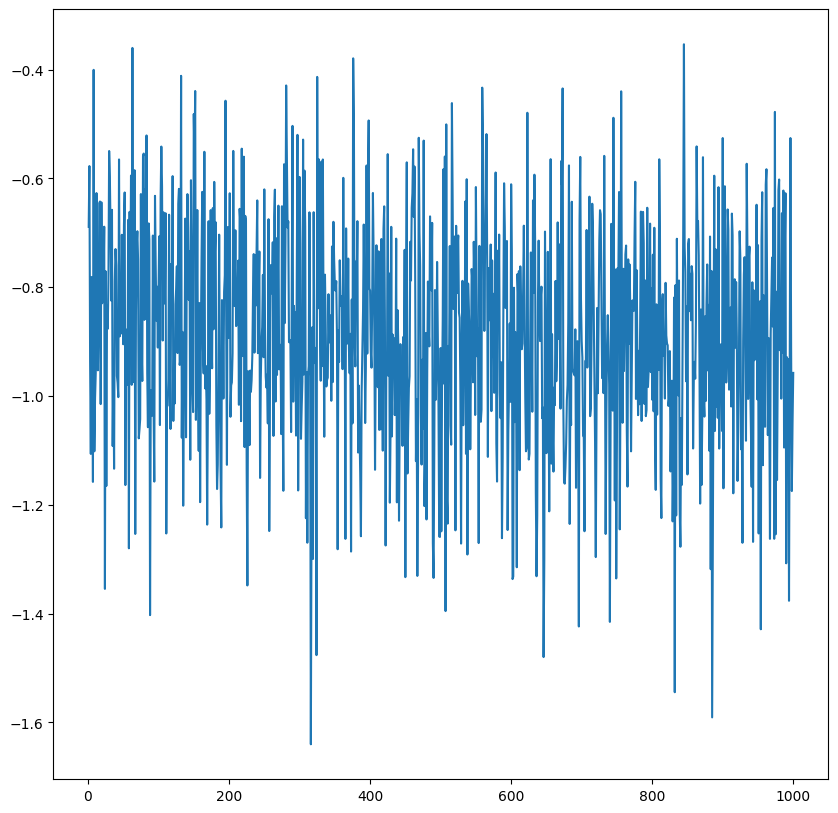

In [26]:
plt.figure(figsize=(10, 10))
plt.plot(_, cost_J)
plt.show()

In [27]:
# テストデータを用いて，精度を見る．
print("テストデータスコア:", accuracy_score(sreg.predict(x_test_fmnist).argmax(axis=1), y_test_fmnist.argmax(axis=1)))

テストデータスコア: 0.8544
